# About
The following analysis consist on identify fruits from a set of images called `datafruit`, that contains 1300 preprocessed images of 100x100 pixels corresponding to distinct types of fruits taken in different position, rotation, size, shape and ripeness.

We will Use some clustering techniques to identify fruits groups. Adicionally, we perform some model selection with Cross Validation and Grid Search to find the best classification model within Neural Networks (Multilayer Perceptron Classifiers), Support Vector Machines, Classification Trees and Adaptative Boosting.

# Libraries

In [12]:
%matplotlib inline
#import skimage
#print(skimage.__version__)
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage import color, viewer, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl
from skimage.util import invert, random_noise, montage
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from IPython.display import display
from scipy.ndimage import affine_transform, zoom
from scipy import misc
from os import walk
import statistics as stats
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.cluster import KMeans
#from Cluster import Cluster #local library
#from tslearn.clustering import KernelKMeans
from sklearn.svm import SVC # Support vector classifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Getting *median* images from RGB representation of fruits images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Trying to recognize patterns from choosing the median as a summary measure of RGB channels:

## Reading `datafruit` images

In [6]:
mypath = "/content/drive/MyDrive/Colab_Notebooks/data_fruits/"
_, _, filenames = next(walk(mypath))
filenames.sort()
 # read the image in  as numpy ndarrays
images = [mpimg.imread(mypath + filename) for filename in filenames]

In [7]:
# getting fruit names:
split_names = [filename.split("_") for filename in filenames]
fruit_names = [name[0] + "_" + name[1] if name[0] == 'Apple' else name[0] for name in split_names]
set(fruit_names)

{'Apple_Braeburn',
 'Apple_Golden',
 'Apple_Granny',
 'Apricot',
 'Avocado',
 'Carambula',
 'Cherry',
 'Huckleberry',
 'Kiwi',
 'Orange',
 'Peach',
 'Pineapple',
 'Strawberry'}

(100, 100, 3) uint8 <class 'numpy.ndarray'>


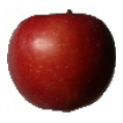

In [8]:
test_image = images[0]
#plotting image:
print(test_image.shape, test_image.dtype, type(test_image))

plt.figure(figsize=(2,2))
plt.imshow(test_image) # display the image
plt.axis('off')
plt.show()

## Getting the median channel of  images:

In [ ]:
median_pixel = [int(stats.median(test_image[:,:,i].reshape(10000))) for i in range(3)]

/home/ed4st/anaconda3/envs/DS/lib/python3.8/statistics.py:435: RuntimeWarning: overflow encountered in ubyte_scalars
  return (data[i - 1] + data[i])/2


**Replicating over all dataset:**

In [ ]:
median_pixels = [[int(stats.median(image[:,:,i].reshape(10000))) for i in range(3)] for image in images]

In [ ]:
median_pixels_df = pd.DataFrame(median_pixels, columns=['red', 'green', 'blue'])
median_pixels_df['fruit'] = fruit_names
median_pixels_df.head()

,red,green,blue,fruit
0,14,32,25,Apple_Braeburn
1,14,32,26,Apple_Braeburn
2,13,32,25,Apple_Braeburn
3,12,30,24,Apple_Braeburn
4,11,30,24,Apple_Braeburn


## Exploring relationships between channels and fruits

**Red vs. Green channels:**

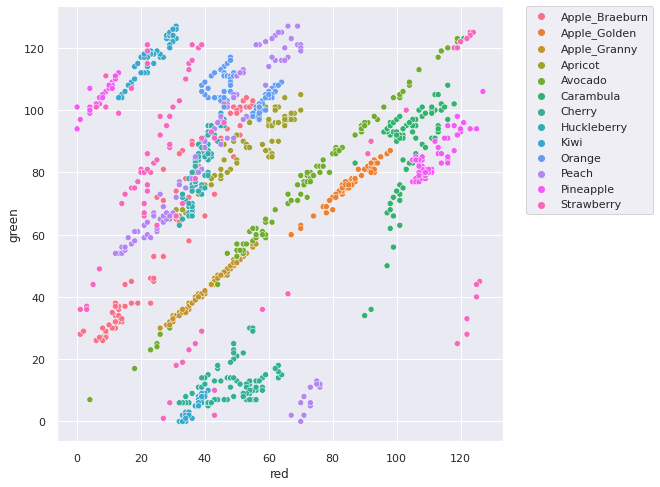

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = median_pixels_df, x = 'red', y = 'green', hue = 'fruit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Red vs. Blue channels:**

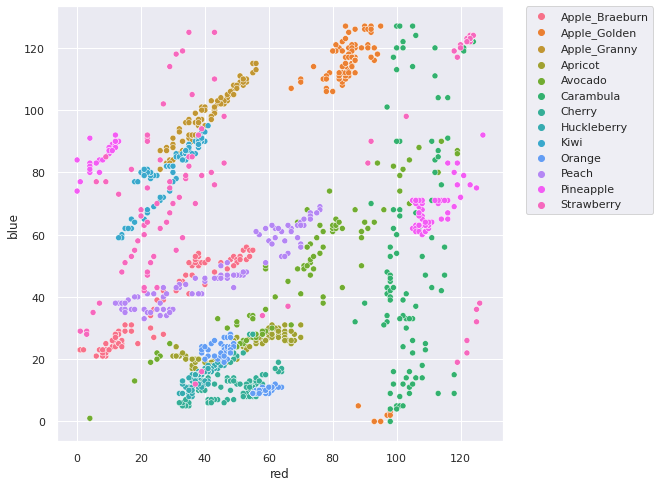

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = median_pixels_df, x = 'red', y = 'blue', hue = 'fruit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Green vs. Blue channels:**

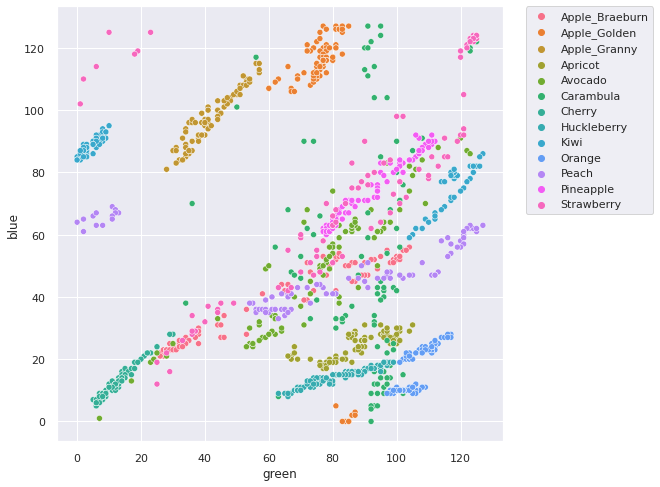

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = median_pixels_df, x = 'green', y = 'blue', hue = 'fruit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Classifying images using PCA and Kernel PCA

## Performing PCA:

**Getting standard data**

In [ ]:
scaler = StandardScaler()
standard_median_pixels = scaler.fit_transform(median_pixels)

In [ ]:
images_pca = PCA(n_components=2)
components = images_pca.fit_transform(standard_median_pixels)
components_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
components_df['fruit'] = fruit_names
components_df.head()

,PC1,PC2,fruit
0,-1.973954,0.258478,Apple_Braeburn
1,-1.959758,0.278794,Apple_Braeburn
2,-1.995695,0.259053,Apple_Braeburn
3,-2.063380,0.279225,Apple_Braeburn
4,-2.085121,0.279801,Apple_Braeburn


**Plotting Principal Components:**

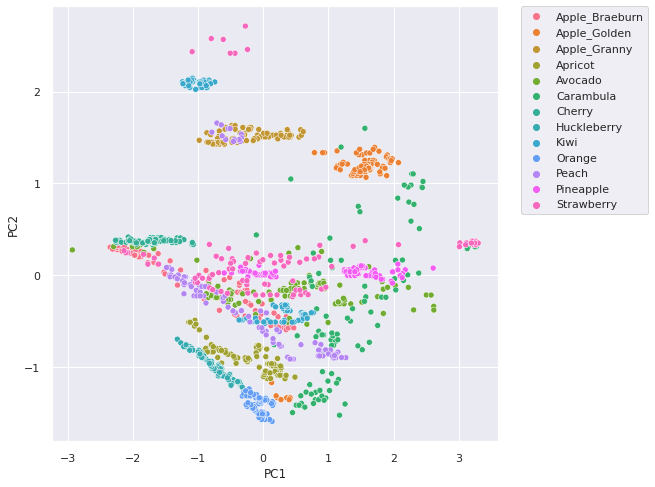

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = components_df, x = 'PC1', y = 'PC2', hue = 'fruit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

It's possible to recognize regions where the fruits are grouped (for example Apple Golden, Apple Granny and Kiwi, among others). However, many of other fruits (like Carambula) are unrecognizable as groups. Then, we could try another technique.

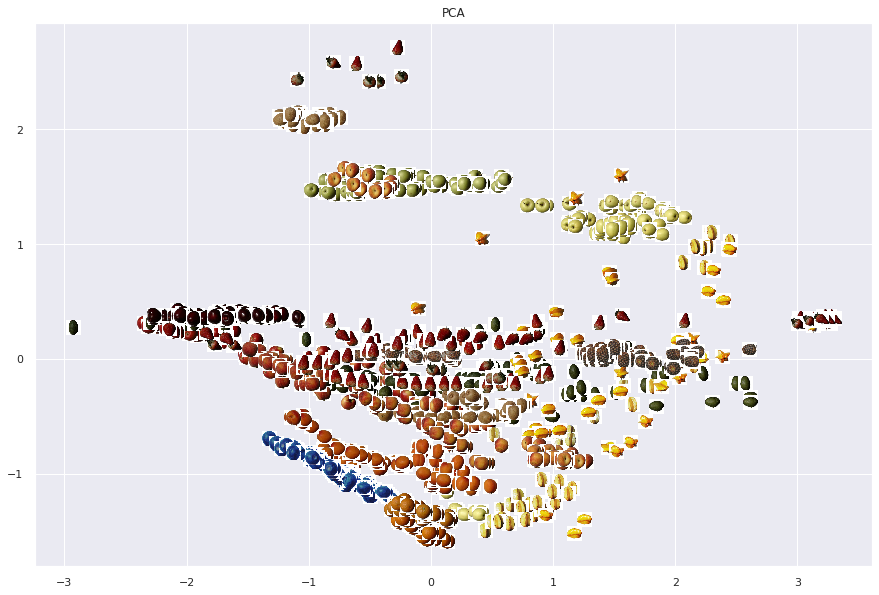

In [ ]:
def get_image(path):
    return OffsetImage(plt.imread('data_fruits/'+path), zoom=.15)

x = components[:,0]
y = components[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y) 
fig.set_size_inches(15, 10, forward=True)
plt.title("PCA")
for x0, y0, path in zip(x, y,filenames):
    ab = AnnotationBbox(get_image(path), (x0, y0), frameon=False )
    ax.add_artist(ab)

## Performing Kernel PCA:

As before, we compute principal components, but instead of using Correlation Matrix, we use the Gramm Matrix given by the *Gaussian Kernel*.

In [ ]:
images_kernel_pca = KernelPCA(n_components = 2, kernel = 'rbf', alpha=0.5)
kernel_components = images_kernel_pca.fit_transform(standard_median_pixels)
kernel_components_df = pd.DataFrame(kernel_components, columns = ['PC1', 'PC2'])
kernel_components_df['fruit'] = fruit_names
kernel_components_df.head()

,PC1,PC2,fruit
0,-0.002956,0.625976,Apple_Braeburn
1,-0.000654,0.627674,Apple_Braeburn
2,0.000226,0.621156,Apple_Braeburn
3,0.017992,0.617446,Apple_Braeburn
4,0.021029,0.611806,Apple_Braeburn


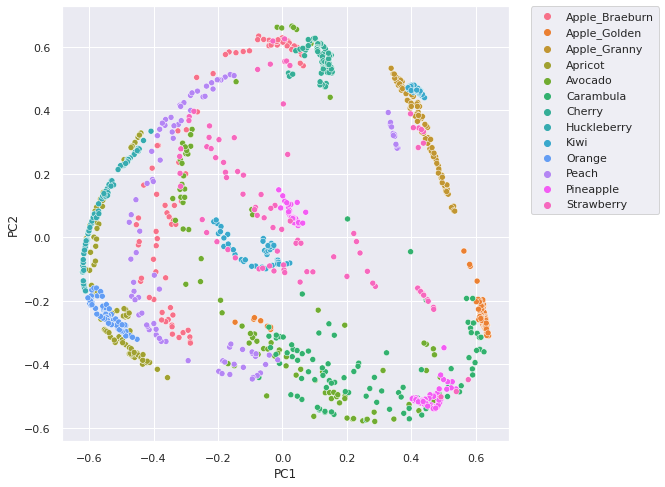

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = kernel_components_df, x = 'PC1', y = 'PC2', hue = 'fruit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

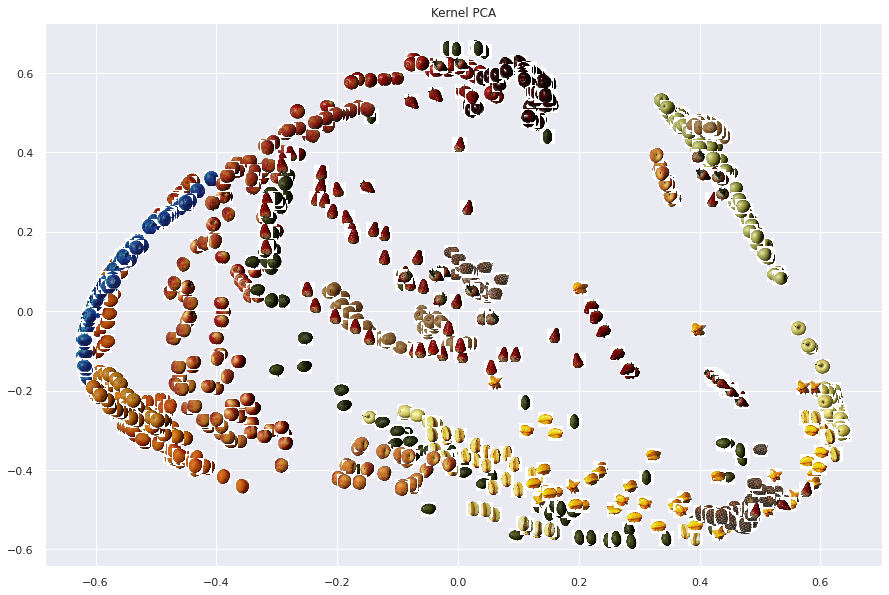

In [ ]:
x = kernel_components[:,0]
y = kernel_components[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y) 
fig.set_size_inches(15, 10, forward=True)
plt.title("Kernel PCA")
for x0, y0, path in zip(x, y,filenames):
    ab = AnnotationBbox(get_image(path), (x0, y0), frameon=False )
    ax.add_artist(ab)

# Clustering fruits

Here, we use **k-means** and **kernel k-means** to cluster fruits data.

## K-means clustering

**Clustering PCA components data with k-means**

In [ ]:
k_means_PCA = KMeans(n_clusters = 13, init = 'random')
clusters = k_means_PCA.fit_predict(components)

k_means_PCA_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
k_means_PCA_df['cluster'] = clusters
k_means_PCA_df['fruit'] = fruit_names

k_means_PCA_df

,PC1,PC2,cluster,fruit
0,-1.973954,0.258478,10,Apple_Braeburn
1,-1.959758,0.278794,10,Apple_Braeburn
2,-1.995695,0.259053,10,Apple_Braeburn
3,-2.063380,0.279225,10,Apple_Braeburn
4,-2.085121,0.279801,10,Apple_Braeburn
...,...,...,...,...
1295,-2.076948,0.246293,10,Strawberry
1296,-2.076948,0.246293,10,Strawberry
1297,-2.107018,0.245934,10,Strawberry
1298,-2.136303,0.267401,10,Strawberry


We can see, for example, that *Apple Braeburn* are well clustered, but it gets confusing when comparing to *Strawberries*. That is principally because they have the same color. Then, we could check another data representation like HSV (Hue Saturation Value)channels.

Text(0.5, 1.0, 'K-Means Clustering with PCA (RGB)')

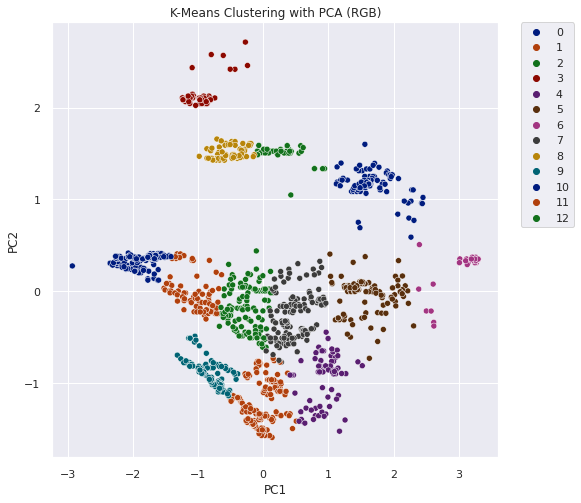

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = k_means_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("K-Means Clustering with PCA (RGB)")

**Clustering kernel PCA components data with k-means**

In [ ]:
k_means_kernel_PCA = KMeans(n_clusters = 13, init = 'random')
clusters = k_means_kernel_PCA.fit_predict(kernel_components)

k_means_kernel_PCA_df = pd.DataFrame(kernel_components, columns=['PC1', 'PC2'])
k_means_kernel_PCA_df['cluster'] = clusters
k_means_kernel_PCA_df['fruit'] = fruit_names

k_means_kernel_PCA_df

,PC1,PC2,cluster,fruit
0,-0.002956,0.625976,0,Apple_Braeburn
1,-0.000654,0.627674,0,Apple_Braeburn
2,0.000226,0.621156,0,Apple_Braeburn
3,0.017992,0.617446,0,Apple_Braeburn
4,0.021029,0.611806,0,Apple_Braeburn
...,...,...,...,...
1295,0.007744,0.553451,0,Strawberry
1296,0.007744,0.553451,0,Strawberry
1297,0.012754,0.554721,0,Strawberry
1298,0.023248,0.540779,0,Strawberry


Text(0.5, 1.0, 'K-Means Clustering with kernel PCA (RGB)')

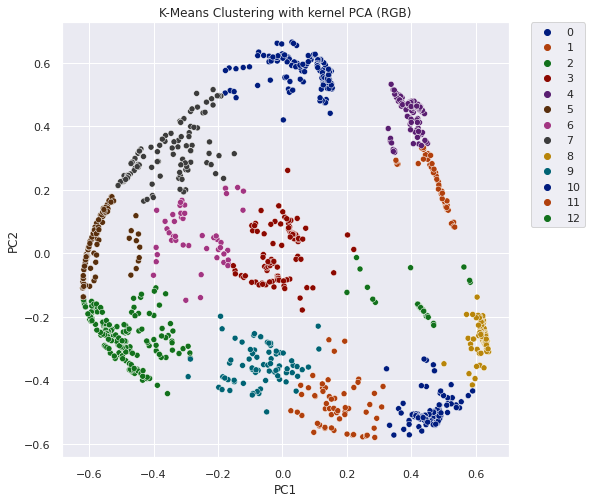

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = k_means_kernel_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("K-Means Clustering with kernel PCA (RGB)")

## Kernel K-Means clustering

**Clustering PCA components data with kernel k-means**

In [ ]:
kk_means_PCA = KernelKMeans(n_clusters = 13, kernel='rbf')
clusters = kk_means_PCA_df = kk_means_PCA.fit_predict(components)
kk_means_PCA_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
kk_means_PCA_df['cluster'] = clusters
kk_means_PCA_df['fruit'] = fruit_names
kk_means_PCA_df

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1300 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,PC1,PC2,cluster,fruit
0,-1.973954,0.258478,12,Apple_Braeburn
1,-1.959758,0.278794,12,Apple_Braeburn
2,-1.995695,0.259053,12,Apple_Braeburn
3,-2.063380,0.279225,12,Apple_Braeburn
4,-2.085121,0.279801,12,Apple_Braeburn
...,...,...,...,...
1295,-2.076948,0.246293,12,Strawberry
1296,-2.076948,0.246293,12,Strawberry
1297,-2.107018,0.245934,12,Strawberry
1298,-2.136303,0.267401,12,Strawberry


Text(0.5, 1.0, 'Kernel K-Means Clustering with PCA (RGB')

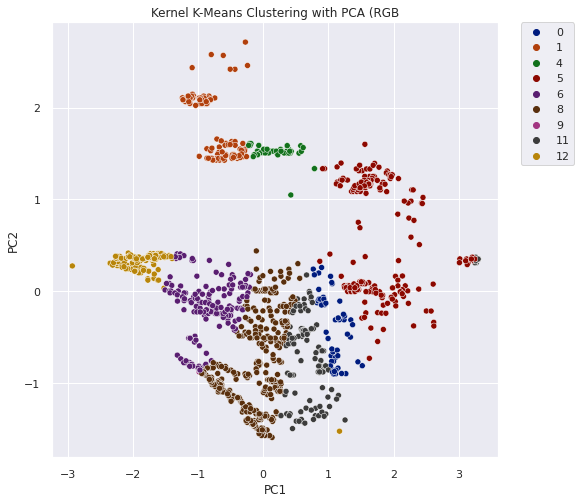

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = kk_means_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Kernel K-Means Clustering with PCA (RGB")

**Clustering kernel PCA components data with kernel k-means**

In [ ]:
kk_means_kernel_PCA = KernelKMeans(n_clusters = 13, kernel='rbf')
clusters = kk_means_PCA_df = kk_means_kernel_PCA.fit_predict(kernel_components)
kk_means_kernel_PCA_df = pd.DataFrame(kernel_components, columns=['PC1', 'PC2'])
kk_means_kernel_PCA_df['cluster'] = clusters
kk_means_kernel_PCA_df['fruit'] = fruit_names
kk_means_kernel_PCA_df

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1300 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,PC1,PC2,cluster,fruit
0,-0.002956,0.625976,12,Apple_Braeburn
1,-0.000654,0.627674,12,Apple_Braeburn
2,0.000226,0.621156,12,Apple_Braeburn
3,0.017992,0.617446,12,Apple_Braeburn
4,0.021029,0.611806,12,Apple_Braeburn
...,...,...,...,...
1295,0.007744,0.553451,12,Strawberry
1296,0.007744,0.553451,12,Strawberry
1297,0.012754,0.554721,12,Strawberry
1298,0.023248,0.540779,12,Strawberry


Text(0.5, 1.0, 'Kernel K-Means Clustering with Kernel PCA (RGB)')

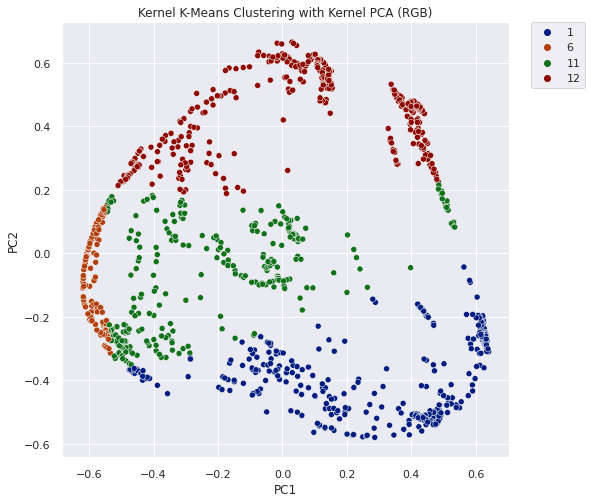

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = kk_means_kernel_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Kernel K-Means Clustering with Kernel PCA (RGB)")

# Clustering with HSV channel representation

In [9]:
images_hsv = [color.rgb2hsv(image) for image in images]

## Getting the three quartiles on each channel per  image:

**Replicating over all dataset:**

In [22]:
percentiles_pixels = [[np.percentile(image[:,:,i], j) for i in range(3) for j in [25,50,75]]\
                      for image in images_hsv]
percentiles_pixels = np.reshape(percentiles_pixels, (1300, 9))

In [23]:
percentiles_pixels_df = pd.DataFrame(percentiles_pixels)#, columns=['red', 'green', 'blue'])
percentiles_pixels_df['fruit'] = fruit_names
percentiles_pixels_df.head()

,0,1,2,3,4,5,6,7,8,fruit
0,0.005051,0.012500,0.035244,0.069064,0.797619,0.894737,0.341176,0.556863,0.862745,Apple_Braeburn
1,0.004950,0.011820,0.033333,0.064725,0.790419,0.892857,0.341176,0.556863,0.863725,Apple_Braeburn
2,0.005051,0.012195,0.031481,0.050109,0.795322,0.895522,0.341176,0.552941,0.870588,Apple_Braeburn
3,0.005747,0.013021,0.034014,0.127845,0.807229,0.896552,0.337255,0.549020,0.788235,Apple_Braeburn
4,0.005747,0.012579,0.031373,0.128751,0.809100,0.900000,0.333333,0.545098,0.789216,Apple_Braeburn


In [24]:
images_hsv_train, images_hsv_test, fruit_names_train, fruit_names_test = train_test_split(percentiles_pixels,
                                                                     fruit_names,
                                                                     test_size = 0.2,
                                                                     random_state = 42)

# Classifying HSV images using PCA and Kernel PCA

## Performing PCA:

**Getting standard data**

In [ ]:
scaler = StandardScaler()
standard_percentiles_pixels = scaler.fit_transform(percentiles_pixels)

In [ ]:
hsv_images_pca = PCA(n_components=2)
components = hsv_images_pca.fit_transform(standard_percentiles_pixels)
components_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
components_df['fruit'] = fruit_names
components_df.head()

,PC1,PC2,fruit
0,-0.190069,1.517189,Apple_Braeburn
1,-0.223447,1.490695,Apple_Braeburn
2,-0.278361,1.452543,Apple_Braeburn
3,0.237921,1.859526,Apple_Braeburn
4,0.239274,1.866875,Apple_Braeburn


**Plotting Principal Components:**

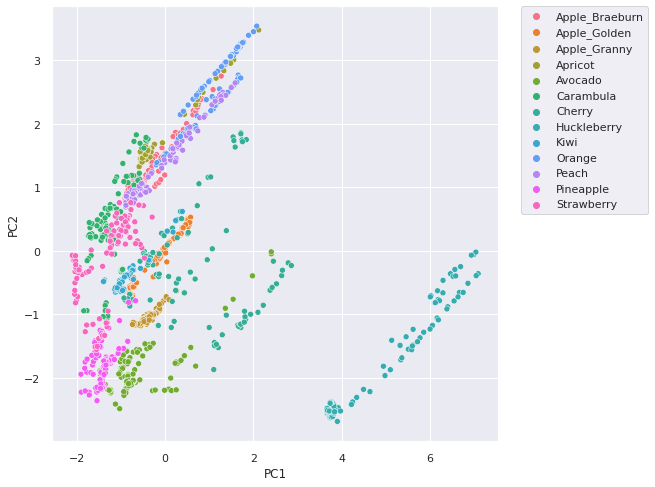

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = components_df, x = 'PC1', y = 'PC2', hue = 'fruit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

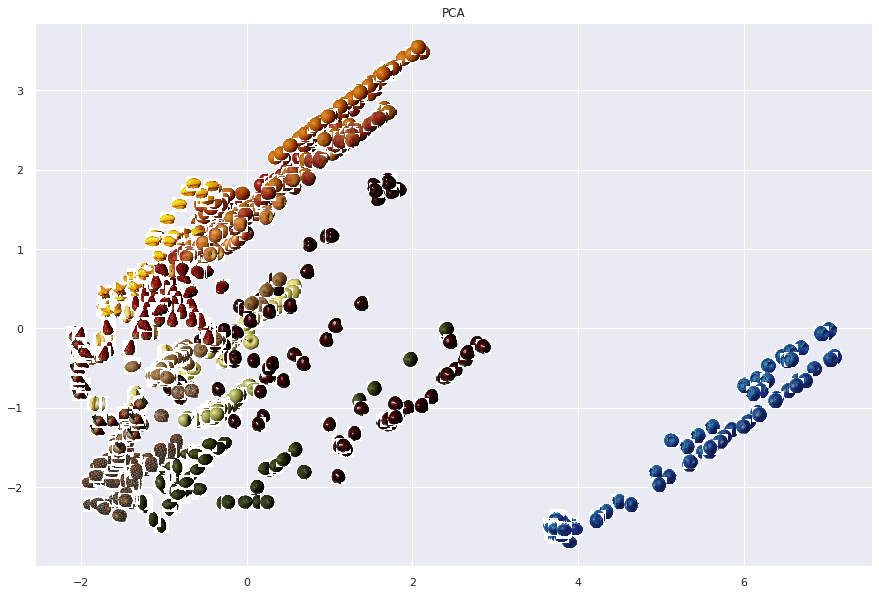

In [ ]:
def get_image(path):
    return OffsetImage(plt.imread('data_fruits/'+path), zoom=.15)

x = components[:,0]
y = components[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y) 
fig.set_size_inches(15, 10, forward=True)
plt.title("PCA")
for x0, y0, path in zip(x, y,filenames):
    ab = AnnotationBbox(get_image(path), (x0, y0), frameon=False )
    ax.add_artist(ab)

## Performing Kernel PCA:

As before, we compute principal components, but instead of using Correlation Matrix, we use the Gramm Matrix given by the *Gaussian Kernel*.

In [ ]:
hsv_images_kernel_pca = KernelPCA(n_components = 2, kernel = 'rbf', alpha=0.5)
kernel_components = hsv_images_kernel_pca.fit_transform(standard_percentiles_pixels)
kernel_components_df = pd.DataFrame(kernel_components, columns = ['PC1', 'PC2'])
kernel_components_df['fruit'] = fruit_names
kernel_components_df.head()

,PC1,PC2,fruit
0,0.451586,0.052467,Apple_Braeburn
1,0.444152,0.047148,Apple_Braeburn
2,0.436877,0.036261,Apple_Braeburn
3,0.479284,0.196595,Apple_Braeburn
4,0.478624,0.201567,Apple_Braeburn


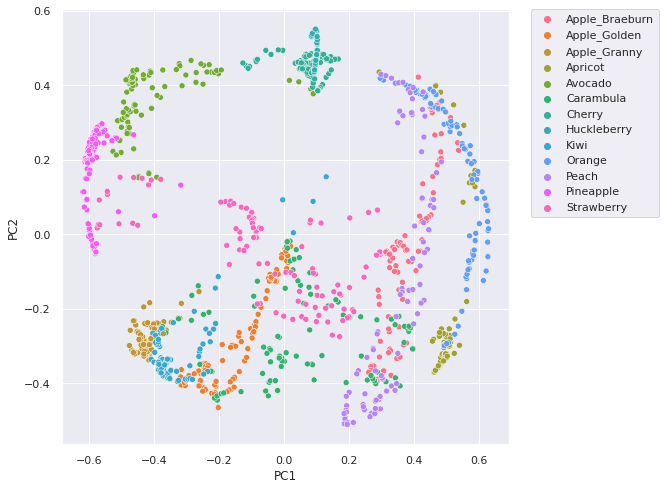

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = kernel_components_df, x = 'PC1', y = 'PC2', hue = 'fruit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

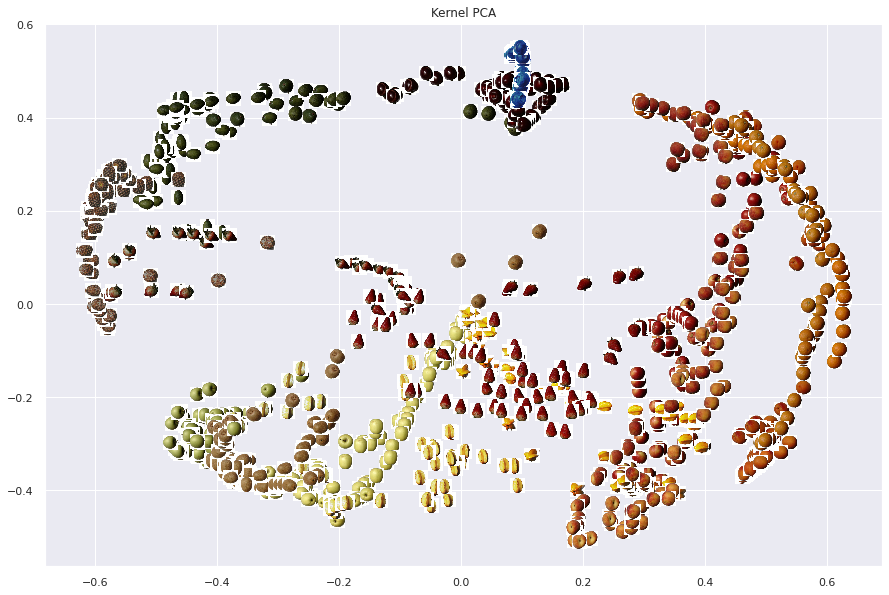

In [ ]:
x = kernel_components[:,0]
y = kernel_components[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y) 
fig.set_size_inches(15, 10, forward=True)
plt.title("Kernel PCA")
for x0, y0, path in zip(x, y,filenames):
    ab = AnnotationBbox(get_image(path), (x0, y0), frameon=False )
    ax.add_artist(ab)

# Clustering fruits

Here, we use **k-means** and **kernel k-means** on HSV representation to cluster fruits data.

## K-means clustering

**Clustering PCA components data with k-means**

In [ ]:
k_means_PCA = KMeans(n_clusters = 13, init = 'random')
clusters = k_means_PCA.fit_predict(components)

k_means_PCA_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
k_means_PCA_df['cluster'] = clusters
k_means_PCA_df['fruit'] = fruit_names

k_means_PCA_df

,PC1,PC2,cluster,fruit
0,-0.190069,1.517189,11,Apple_Braeburn
1,-0.223447,1.490695,11,Apple_Braeburn
2,-0.278361,1.452543,11,Apple_Braeburn
3,0.237921,1.859526,1,Apple_Braeburn
4,0.239274,1.866875,1,Apple_Braeburn
...,...,...,...,...
1295,-0.577120,0.727440,9,Strawberry
1296,-0.594715,0.720224,9,Strawberry
1297,-0.591284,0.720563,9,Strawberry
1298,-0.774448,0.759336,9,Strawberry


We can see, for example, that *Apple Braeburn* are well clustered, but it gets confusing when comparing to *Strawberries*. That is principally because they have the same color. Then, we could check another data representation like HSV (Hue Saturation Value)channels.

Text(0.5, 1.0, 'K-Means Clustering with PCA (RGB)')

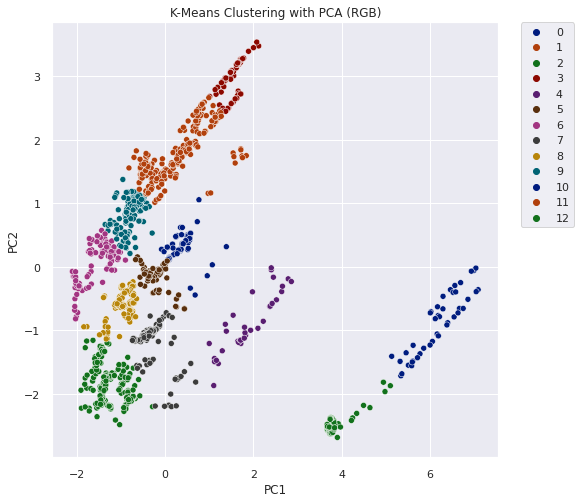

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = k_means_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("K-Means Clustering with PCA (RGB)")

**Clustering kernel PCA components data with k-means**

In [ ]:
k_means_kernel_PCA = KMeans(n_clusters = 13, init = 'random')
clusters = k_means_kernel_PCA.fit_predict(kernel_components)

k_means_kernel_PCA_df = pd.DataFrame(kernel_components, columns=['PC1', 'PC2'])
k_means_kernel_PCA_df['cluster'] = clusters
k_means_kernel_PCA_df['fruit'] = fruit_names

k_means_kernel_PCA_df

,PC1,PC2,cluster,fruit
0,0.451586,0.052467,12,Apple_Braeburn
1,0.444152,0.047148,12,Apple_Braeburn
2,0.436877,0.036261,12,Apple_Braeburn
3,0.479284,0.196595,6,Apple_Braeburn
4,0.478624,0.201567,6,Apple_Braeburn
...,...,...,...,...
1295,0.295952,-0.053321,12,Strawberry
1296,0.293768,-0.050079,12,Strawberry
1297,0.293976,-0.046987,12,Strawberry
1298,0.283878,-0.055840,12,Strawberry


Text(0.5, 1.0, 'K-Means Clustering with kernel PCA (RGB)')

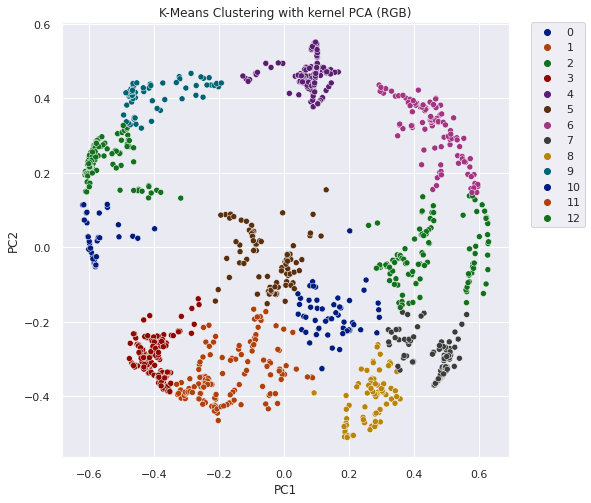

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = k_means_kernel_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("K-Means Clustering with kernel PCA (RGB)")

## Kernel K-Means clustering

**Clustering PCA components data with kernel k-means**

In [ ]:
kk_means_PCA = KernelKMeans(n_clusters = 13, kernel='rbf')
clusters = kk_means_PCA_df = kk_means_PCA.fit_predict(components)
kk_means_PCA_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
kk_means_PCA_df['cluster'] = clusters
kk_means_PCA_df['fruit'] = fruit_names
kk_means_PCA_df

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1300 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,PC1,PC2,cluster,fruit
0,-0.190069,1.517189,8,Apple_Braeburn
1,-0.223447,1.490695,8,Apple_Braeburn
2,-0.278361,1.452543,7,Apple_Braeburn
3,0.237921,1.859526,11,Apple_Braeburn
4,0.239274,1.866875,11,Apple_Braeburn
...,...,...,...,...
1295,-0.577120,0.727440,1,Strawberry
1296,-0.594715,0.720224,1,Strawberry
1297,-0.591284,0.720563,1,Strawberry
1298,-0.774448,0.759336,7,Strawberry


Text(0.5, 1.0, 'Kernel K-Means Clustering with PCA (RGB')

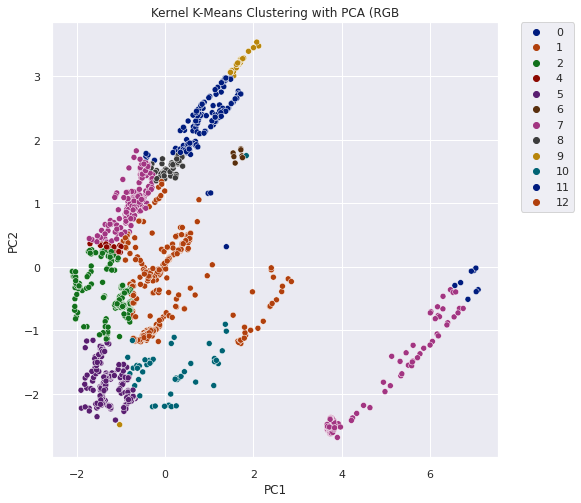

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = kk_means_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Kernel K-Means Clustering with PCA (RGB")

**Clustering kernel PCA components data with kernel k-means**

In [ ]:
kk_means_kernel_PCA = KernelKMeans(n_clusters = 13, kernel='rbf')
clusters = kk_means_PCA_df = kk_means_kernel_PCA.fit_predict(kernel_components)
kk_means_kernel_PCA_df = pd.DataFrame(kernel_components, columns=['PC1', 'PC2'])
kk_means_kernel_PCA_df['cluster'] = clusters
kk_means_kernel_PCA_df['fruit'] = fruit_names
kk_means_kernel_PCA_df

/home/ed4st/anaconda3/envs/DS/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1300 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,PC1,PC2,cluster,fruit
0,0.451586,0.052467,8,Apple_Braeburn
1,0.444152,0.047148,8,Apple_Braeburn
2,0.436877,0.036261,8,Apple_Braeburn
3,0.479284,0.196595,8,Apple_Braeburn
4,0.478624,0.201567,8,Apple_Braeburn
...,...,...,...,...
1295,0.295952,-0.053321,8,Strawberry
1296,0.293768,-0.050079,8,Strawberry
1297,0.293976,-0.046987,8,Strawberry
1298,0.283878,-0.055840,8,Strawberry


Text(0.5, 1.0, 'Kernel K-Means Clustering with Kernel PCA (RGB)')

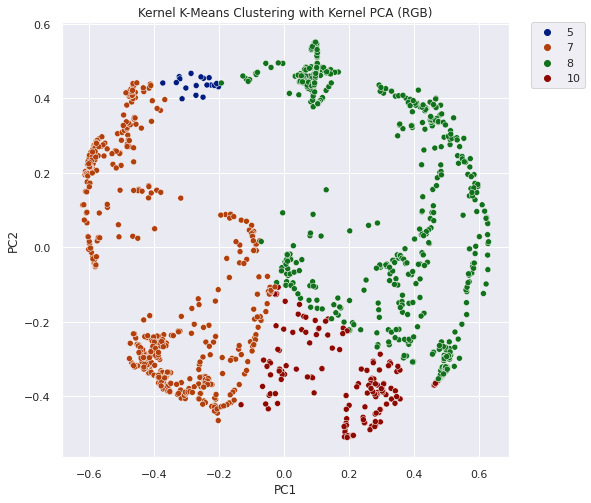

In [ ]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(data = kk_means_kernel_PCA_df, x = 'PC1', y = 'PC2', hue = 'cluster', palette='dark')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Kernel K-Means Clustering with Kernel PCA (RGB)")

# Classifying Fruits

## Neural Network

In [25]:
parameters = [
  {'hidden_layer_sizes': [[10,],[10,10], [10,2]], 'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}
]
mlp = MLPClassifier(solver='lbfgs', random_state=0)
GS = GridSearchCV(estimator=mlp, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(images_hsv_train,fruit_names_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=0, shuffle=True,
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'a

In [26]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 

Best score: 0.9903846153846155
Best C: MLPClassifier(activation='relu', alpha=0.5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[10, 10], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


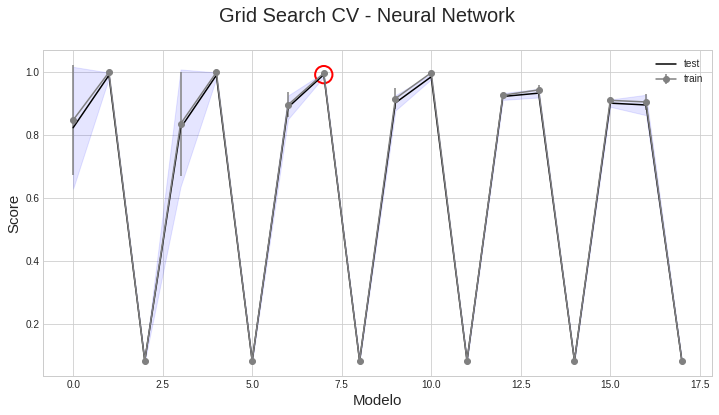

In [27]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Neural Network',size=20)
plt.legend(loc="best")
plt.show()

## Support Vector Machine

In [34]:
parameters = [
    {'kernel': ['linear'], "C":[0.01,0.5,10]},
    {'kernel':['rbf'], 'gamma': [1,10,.1,.5, 2], 'C': [0.01,0.5,10]}
]
svm = SVC()
GS = GridSearchCV(estimator=svm, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(images_hsv_train,fruit_names_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.01, 0.5, 10], 'kernel': ['linear']},
                         {'C': [0.01, 0.5, 10], 'gamma': [1, 10, 0.1, 0.5, 2],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [35]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 

Best score: 1.0
Best C: SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


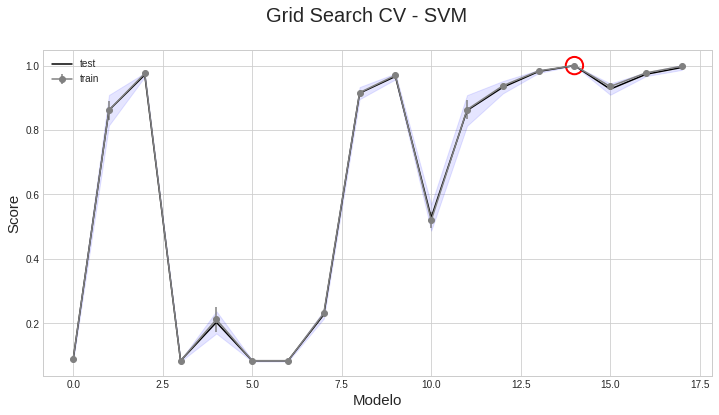

In [36]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - SVM',size=20)
plt.legend(loc="best")
plt.show()

## Classification Tree

In [38]:
parameters = [
    {'max_depth': [2,4,6, 10], "ccp_alpha":[0.01, 0.1, 1, 10]}
]
ctree = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(estimator=ctree, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(images_hsv_train,fruit_names_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'ccp_alpha': [0.01, 0.1, 1, 10],
                          'max_depth': [2, 4, 6, 10]}],
             p

In [39]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 

Best score: 0.9865384615384617
Best C: DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


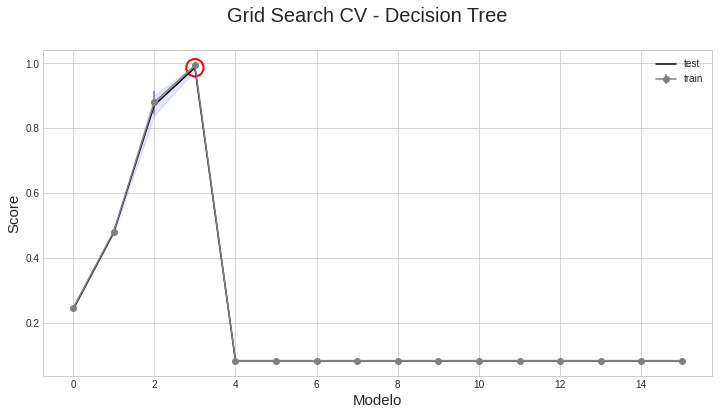

In [40]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Decision Tree',size=20)
plt.legend(loc="best")
plt.show()

In [41]:
parameters = [
    {'n_estimators': [10,20,50,100], "learning_rate":[ 0.1, 1, 1.5, 10]}
]
ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), algorithm="SAMME")
GS = GridSearchCV(estimator=ada_classifier, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(images_hsv_train,fruit_names_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=2,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
      

In [42]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_) 

Best score: 0.9846153846153847
Best C: AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='de

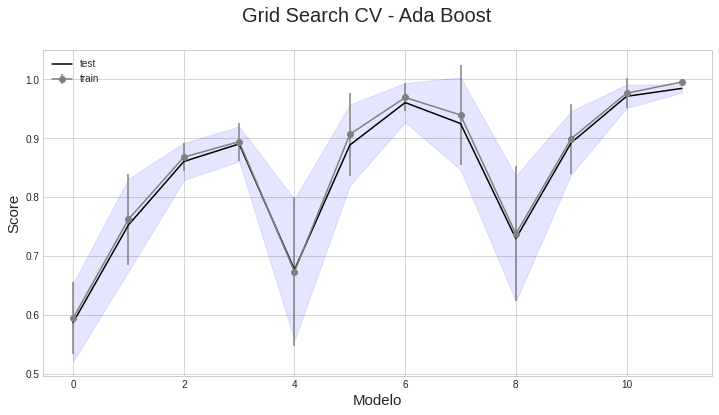

In [43]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Ada Boost',size=20)
plt.legend(loc="best")
plt.show()